# (26) MEI

**Motivation**: MEI fits. <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_PoissonVAE'))
from analysis.eval import sparse_score
from figures.fighelper import *
from vae.train_vae import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
device_idx = 0
device = f'cuda:{device_idx}'

In [3]:
from analysis.mei import MEI

In [4]:
def _show_pairwise(i, j):
    df = pd.DataFrame({
        f'z-{i}': etc['r*dr'][:, i],
        f'z-{j}': etc['r*dr'][:, j],
        f'z-{i}_log': np.log(etc['r*dr'][:, i]),
        f'z-{j}_log': np.log(etc['r*dr'][:, j]),
        'lbl': tonp(tr.dl_vld.dataset.tensors[1]).astype(int),
    })
    fig, axes = create_figure(1, 2, (8, 4.5), layout='constrained')
    sns.scatterplot(data=df, x=f'z-{i}', y=f'z-{j}', hue='lbl', palette='tab10', s=20, ax=axes[0])
    sns.scatterplot(data=df, x=f'z-{i}_log', y=f'z-{j}_log', hue='lbl', palette='tab10', s=5, legend=False, ax=axes[1])
    axes[1].axvline(0, color='k', ls='--', lw=1.0, zorder=0)
    axes[1].axhline(0, color='k', ls='--', lw=1.0, zorder=0)
    ax_square(axes)
    plt.show()

## Poisson

In [5]:
name = '/'.join([
    # 'poisson_uniform_c(-3)_rmax(1)_MNIST_z-10_k-32_<conv+b|conv+b>',
    # 'init0.05_warm2_mc_b200-ep1200-lr(0.002)_beta(1:0x0.5)_temp(0.05:lin-0.5)_gr(1000)_(2024_05_01,20:10)',

    # 'poisson_uniform_c(-3)_rmax(1)_MNIST_z-10_k-32_<conv+b|conv+b>',
    # 'initscale-0.05_warmrestart-2_mc_b200-ep1200-lr(0.002)_beta(1:0x0.5)_temp(0.05:lin-0.5)_gr(1000)_(2024_05_01,17:07)', # checkpoint: 1050
    
    # 'poisson_uniform_c(-3)_rmax(1)_MNIST_z-10_k-32_<conv+b|conv+b>',
    # 'init-scale-0.05_mc_b200-ep900-lr(0.002)_beta(1:0x0.5)_temp(0.05:lin-0.5)_gr(1000)_(2024_05_01,10:31)',
    
    'poisson_uniform_c(-3)_rmax(1)_MNIST_z-10_k-32_<conv+b|conv+b>',
    'ResConvPool-SwishOnlyOnRes_mc_b200-ep900-lr(0.002)_beta(1:0x0.5)_temp(0.05:lin-0.5)_gr(1000)_(2024_04_30,21:50)',
])
tr, meta = load_quick(name, device=device, lite=False)
data, loss, etc = tr.validate()

print(meta)

{
    'timestamp': '2024_04_30,21:50',
    'checkpoint': 900,
    'global_step': 270000,
    'file': 'PoissonVAE+TrainerVAE-0900_(2024_05_01,00:24).pt',
    'path': 
'/home/hadi/Projects/PoissonVAE/models/poisson_uniform_c(-3)_rmax(1)_MNIST_z-10_k-32_<conv+b|conv+b>/ResConvPool-Sw
ishOnlyOnRes_mc_b200-ep900-lr(0.002)_beta(1:0x0.5)_temp(0.05:lin-0.5)_gr(1000)_(2024_04_30,21:50)'
}

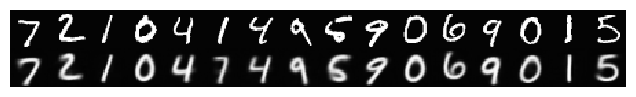

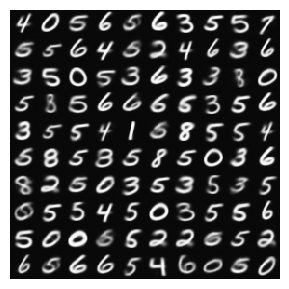

In [6]:
tr.show_recon(0.0), tr.show_samples(0.0);

## MEI

In [7]:
def func_kl(model, x, which_k, alpha=0.0):
    log_dr = model.encode(x)
    kl = model.loss_kl(log_dr).sum()
    y = log_dr.squeeze()[which_k]
    return y - kl.mul(alpha)


def func_silence(model, x, which_k, alpha=0.0):
    log_dr = model.encode(x).squeeze()
    y = log_dr[which_k]
    
    mask = torch.ones(model.cfg.n_latents, dtype=torch.bool)
    mask[which_k] = False
    reg = log_dr[mask].exp().sum()
    
    return y - reg.mul(alpha)

In [8]:
def _do_it(which_k: int, alpha: float, func):
    mei = MEI(
        model=tr.model,
        func=func,
        maximize=True,
        n_iter=120,
        kws_optim={
            'lr': 0.1,
            'weight_decay': 0.15},
    ).to(device)

    # fit
    mei.fit(which_k, alpha, verbose=False)
    x2p = tonp(mei._x().squeeze())

    # plot
    fig, axes = create_figure(1, 3, (9, 2.1), width_ratios=[0.7, 1, 1], layout='constrained')
    
    im = axes[0].imshow(x2p, cmap='Greys_r')
    plt.colorbar(im, ax=axes[0])
    
    axes[1].plot(mei.stats['y'], label='log_dr')
    _y = mei.stats['y'][-1]
    axes[1].axhline(_y, color='r', ls='--', label=f"y = {_y:0.4f}")
    axes[2].plot(np.log(mei.stats['g_norm']), label='log(g_norm)')
    
    axes[0].set_title(f"norm  = {mei.x.norm().item():0.3f}")
    add_legend(axes[1:])
    plt.show()

    return x2p, _y

  0%|                                                     | 0/1 [00:00<?, ?it/s]

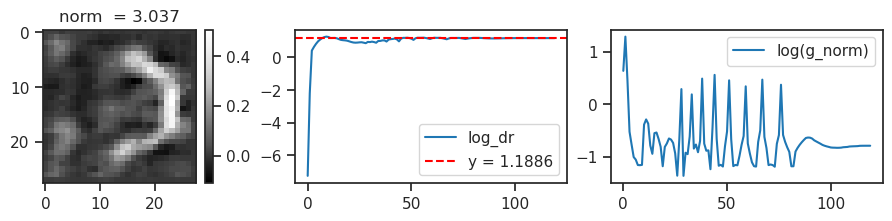

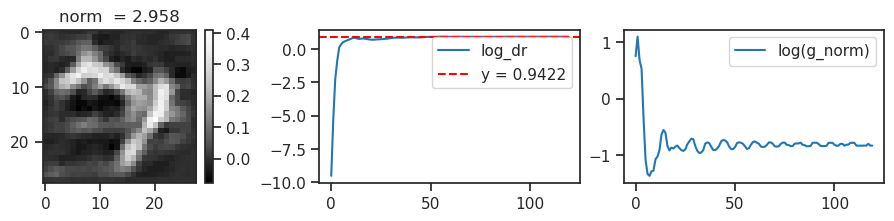

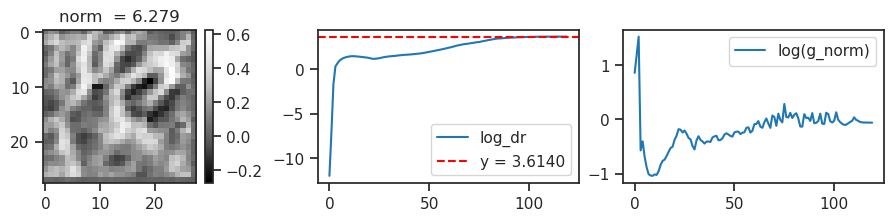

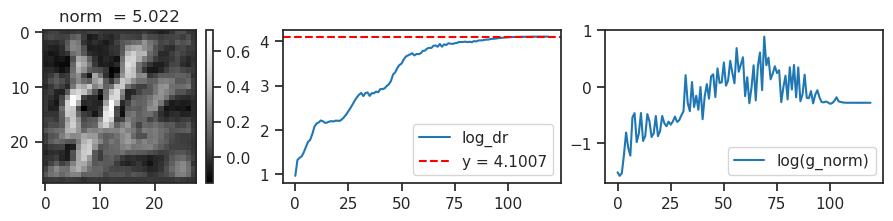

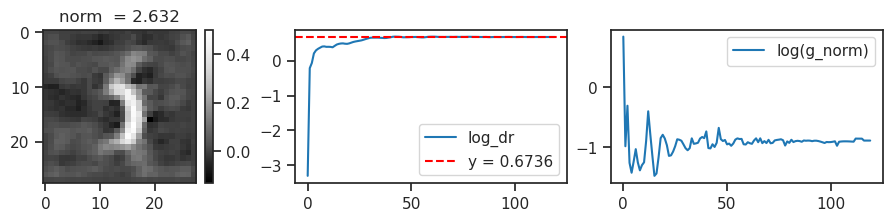

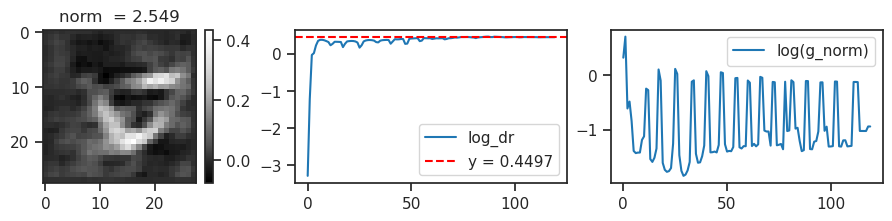

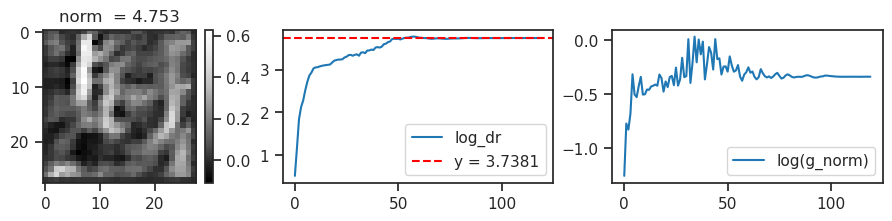

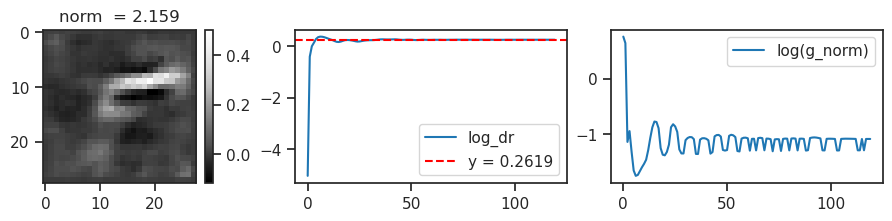

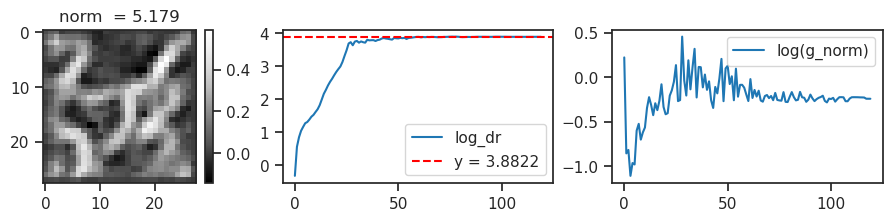

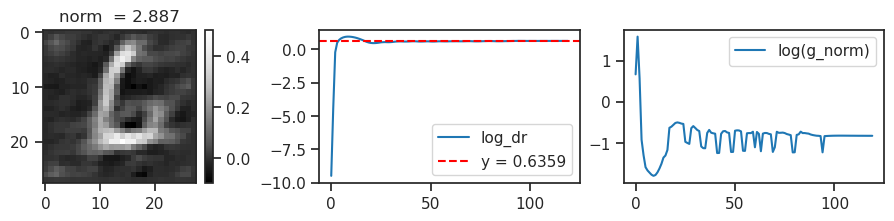

100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.65s/it]


In [9]:
alphas = [0.001] # , 0.001, 0.01, 0.1]
mei_all = {
    a: np.zeros((tr.model.cfg.n_latents, 28, 28))
    for a in alphas
}
y_all = {
    a: np.zeros(tr.model.cfg.n_latents)
    for a in alphas
}
for i, a in tqdm(enumerate(alphas), total=len(alphas), ncols=80):
    for j in range(tr.model.cfg.n_latents):
        mei_all[a][j], y_all[a][j] = _do_it(j, a, func_kl);

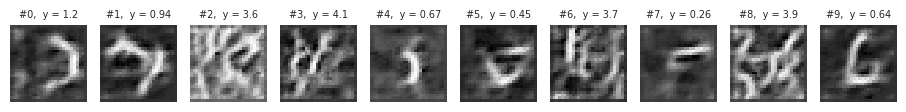

In [10]:
cmap = 'Greys_r'

fig, axes = create_figure(len(alphas), tr.model.cfg.n_latents, (9, 1.0 * len(alphas)), 'all', 'all', 'constrained')
axes = axes.reshape((len(alphas), tr.model.cfg.n_latents))
for j in range(tr.model.cfg.n_latents):
    for i, a in enumerate(alphas):
        axes[i, j].imshow(mei_all[a][j], cmap=cmap)
        axes[i, j].set_title(f"#{j},  y = {y_all[a][j]:0.2g}", fontsize=7)
remove_ticks(axes)
plt.show()

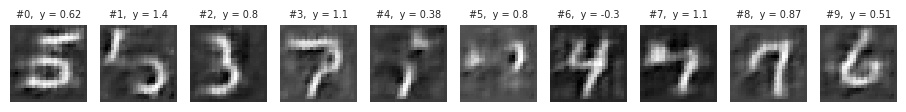

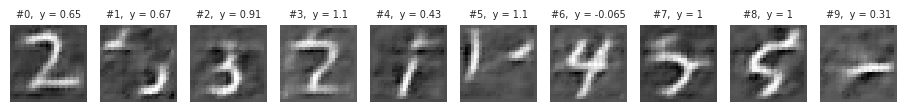

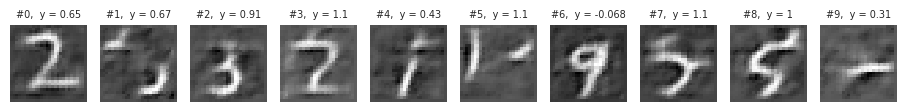

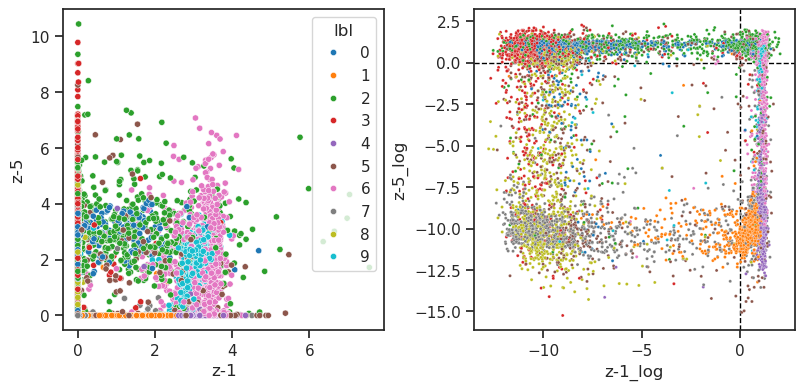

In [13]:
_show_pairwise(1, 5)

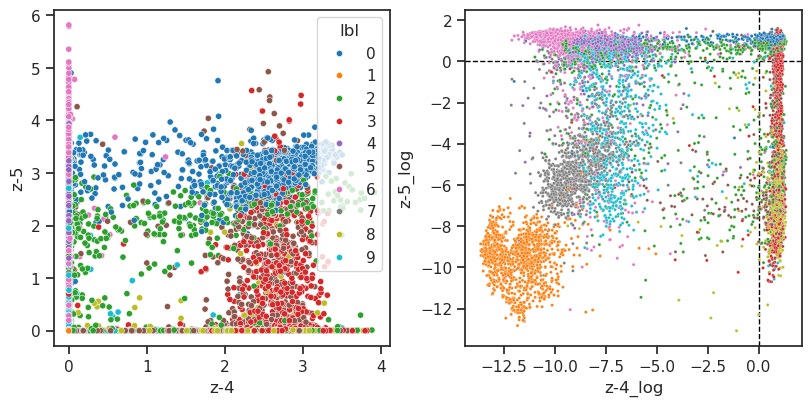

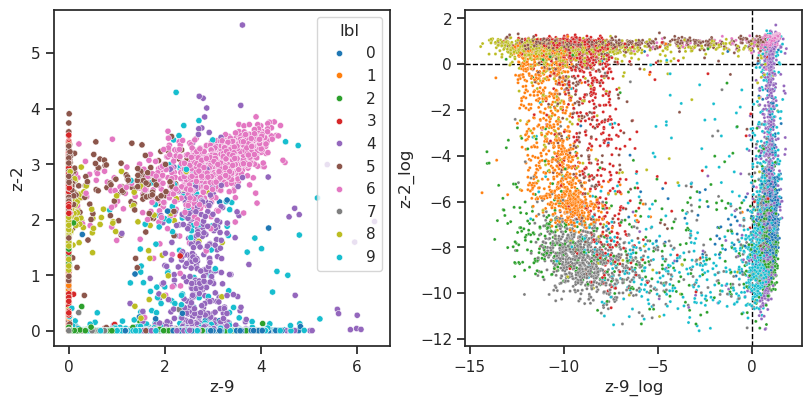

tensor([ 0.0177, -0.0224, -0.0028,  0.0305,  0.0457,  0.0547,  0.0349,  0.0211,
         0.0512, -0.0089], device='cuda:0')

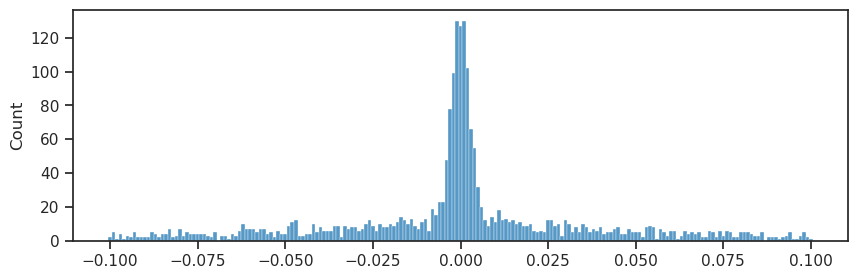

In [37]:
fig, ax = create_figure(1, 1, (10, 3))
sns.histplot(
    tonp(tr.model.fc_enc.weight.data).ravel(),
    bins=np.linspace(-0.1, 0.1 + 0.001, 202) - 0.0005,
);
tr.model.fc_enc.bias.data

tensor([-4.9805e-05, -1.1153e-03, -2.6188e-03,  ..., -3.2359e-03,
         1.1214e-03,  1.5004e-03], device='cuda:0')

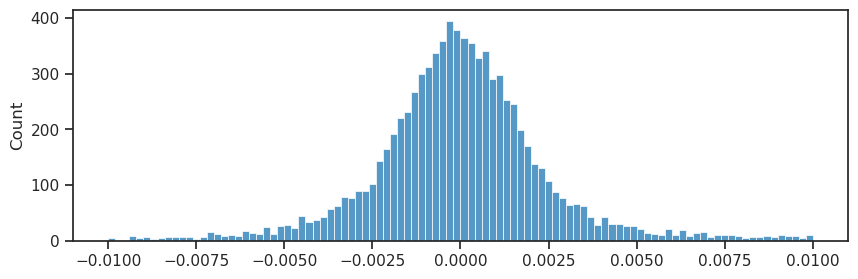

In [38]:
fig, ax = create_figure(1, 1, (10, 3))
sns.histplot(
    tonp(tr.model.fc_dec.weight.data).ravel(),
    bins=np.linspace(-0.01, 0.01, 101),
);
tr.model.fc_dec.bias.data

In [11]:
data, loss, etc = tr.forward('vld', temp=0.0, full_data=True)

In [12]:
df, df_summary = knn_analysis(
    x=etc['log_dr'],
    y=data['g'].astype(int),
    n_iter=100,
    verbose=True,
)

train sample size: 5000, iter #0: 100%|█████████████████| 801/801 [01:40<00:00,  8.00it/s]


In [13]:
df_summary

mean       std
size                    
20    0.418638  0.062253
50    0.658010  0.055708
100   0.796354  0.034670
200   0.882576  0.021348
500   0.936824  0.010214
1000  0.953332  0.007023
2000  0.960502  0.005561
4000  0.963162  0.002998
5000  0.962600       NaN

  0%|                                                     | 0/4 [00:00<?, ?it/s]

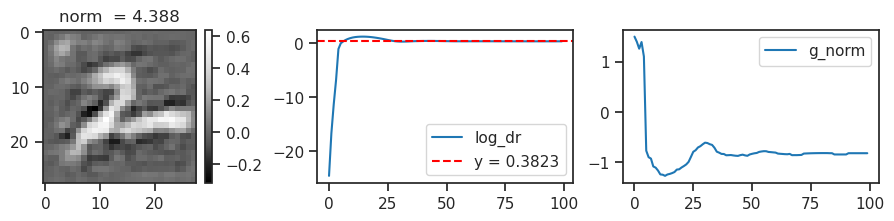

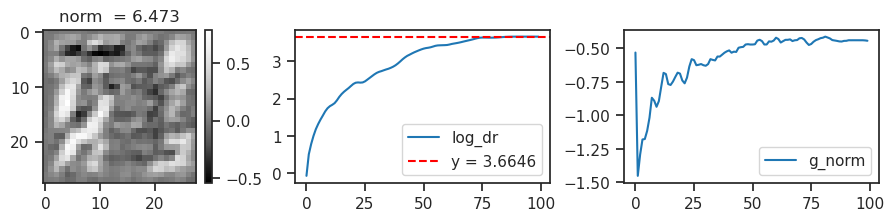

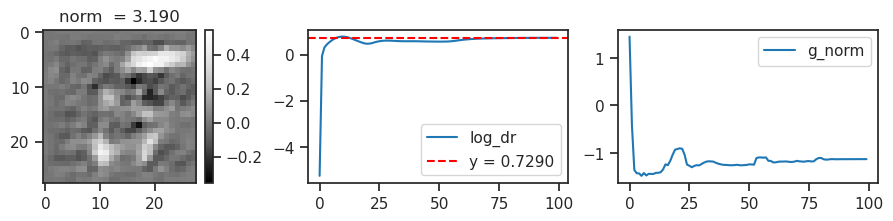

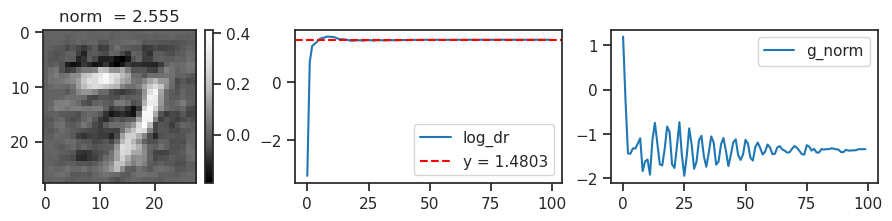

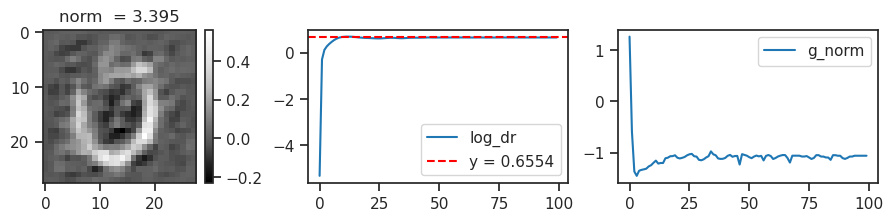

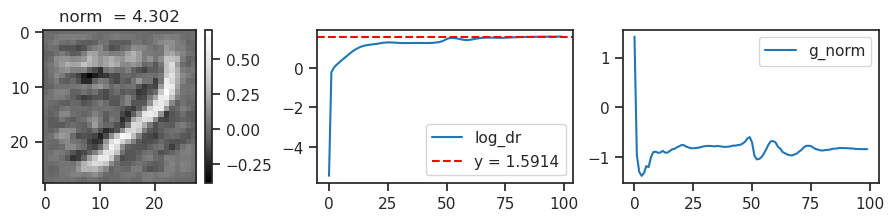

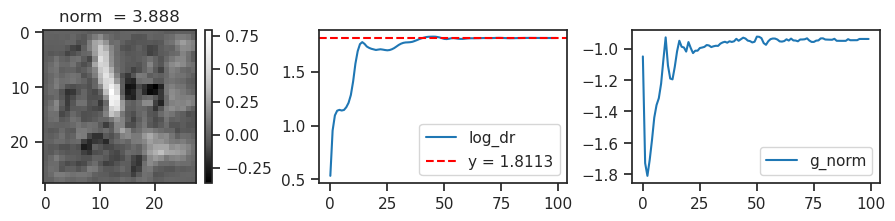

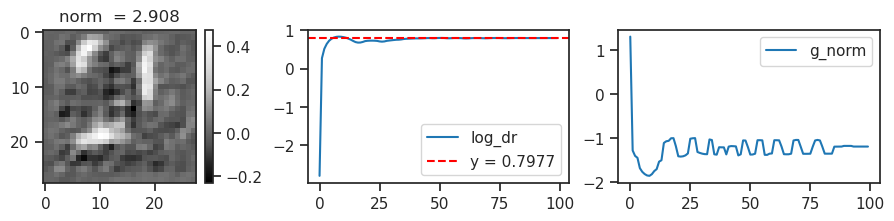

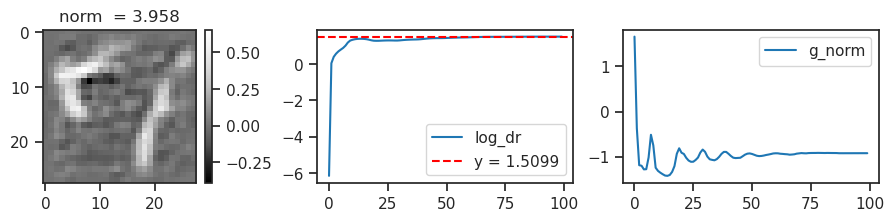

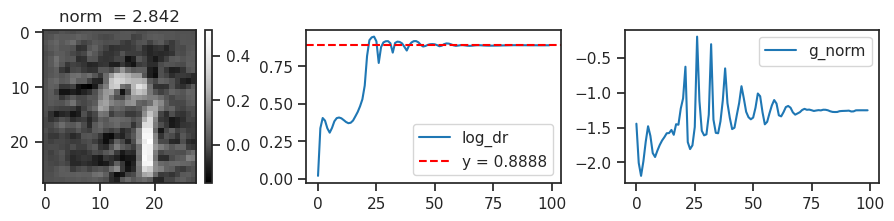

 25%|███████████▎                                 | 1/4 [00:13<00:39, 13.23s/it]

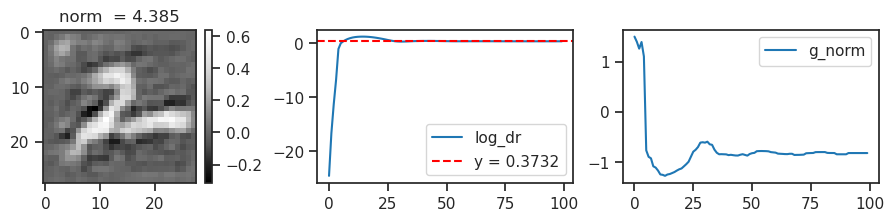

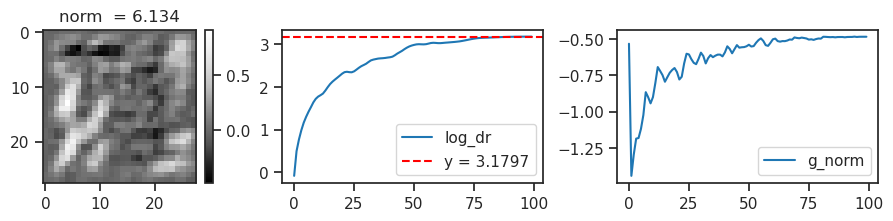

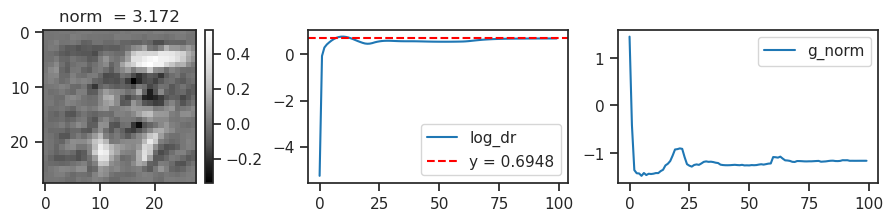

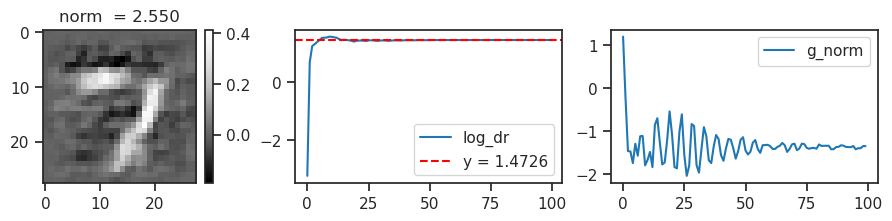

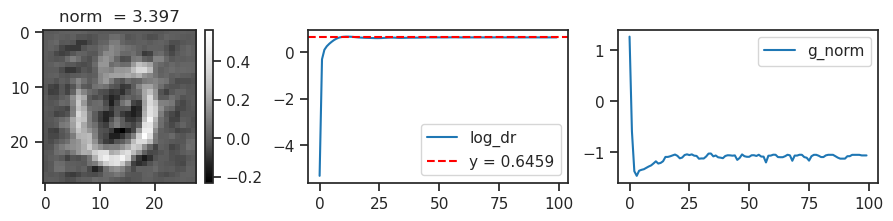

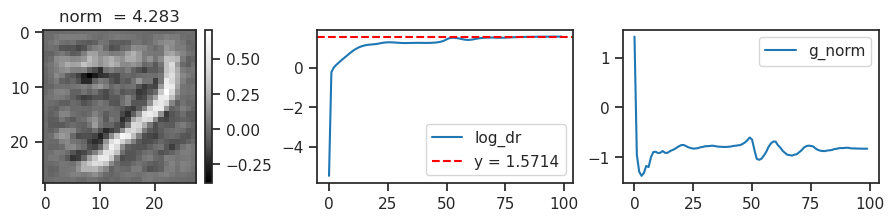

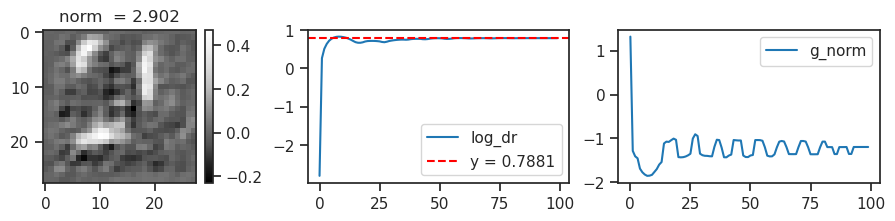

 50%|██████████████████████▌                      | 2/4 [00:26<00:26, 13.30s/it]

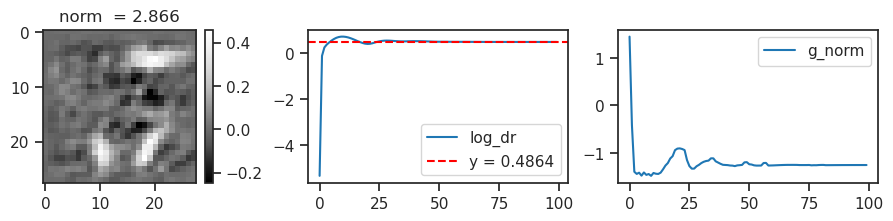

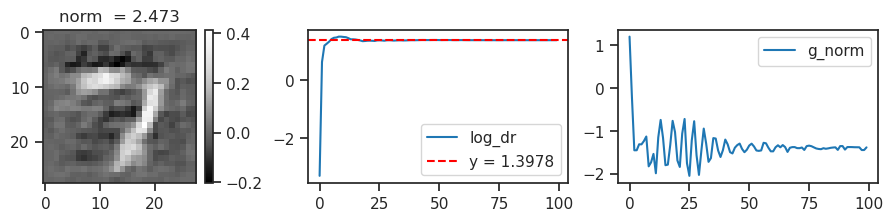

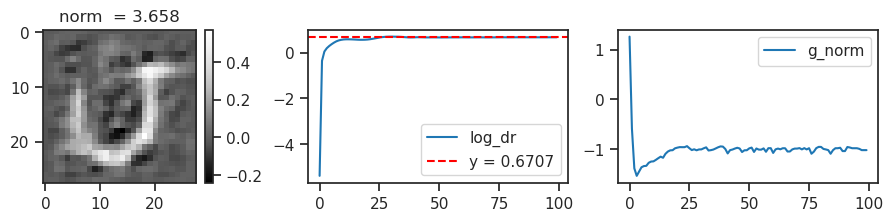

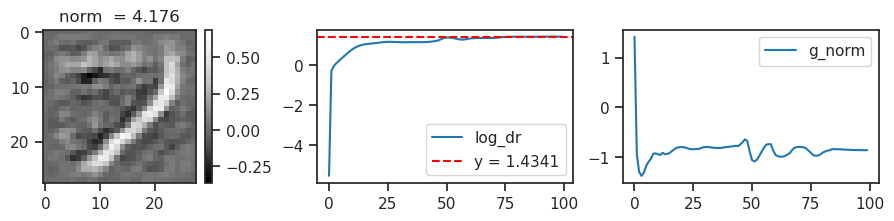

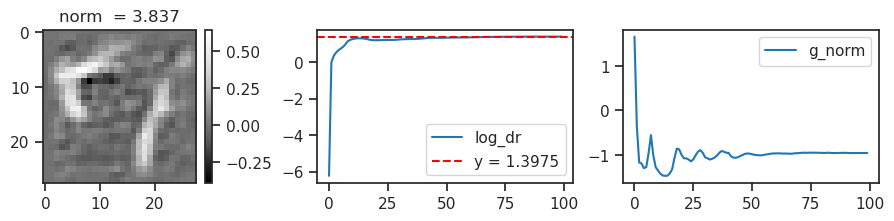

 75%|█████████████████████████████████▊           | 3/4 [00:40<00:13, 13.51s/it]

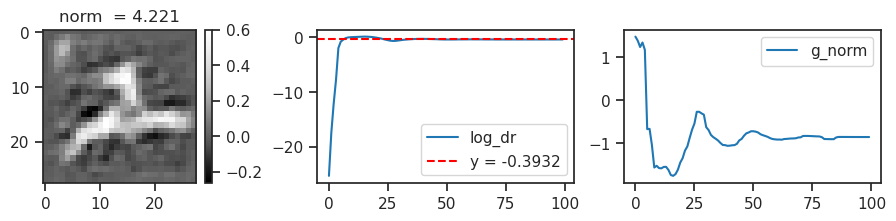

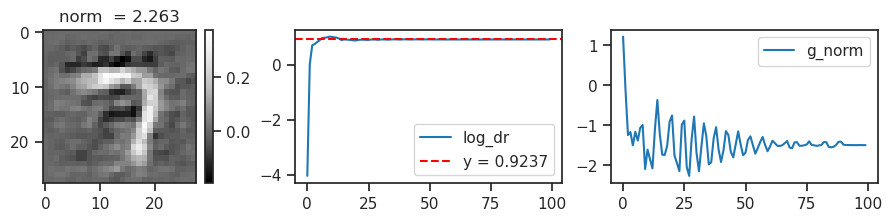

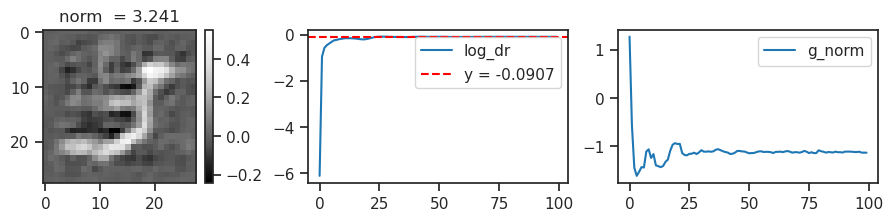

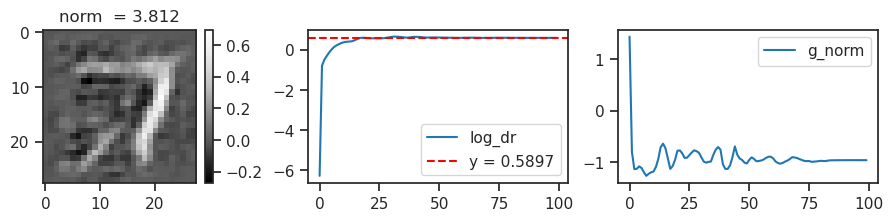

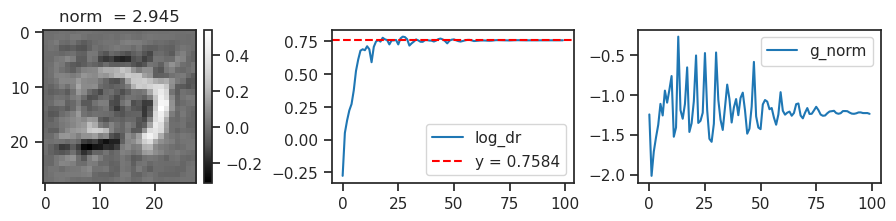

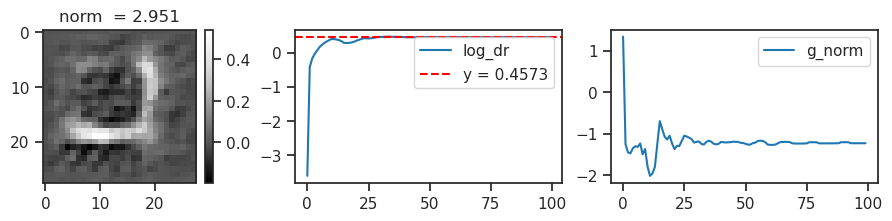

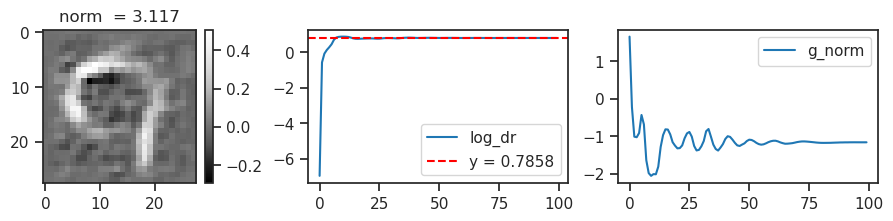

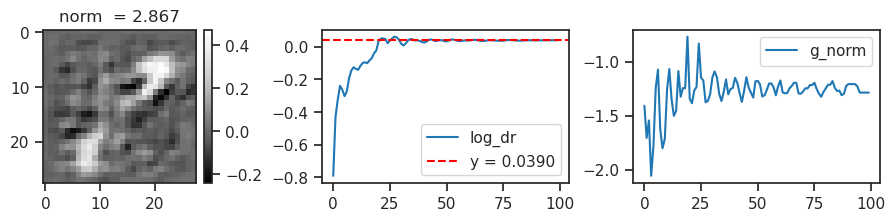

100%|█████████████████████████████████████████████| 4/4 [00:54<00:00, 13.51s/it]


In [32]:
### Was: 'mc_ep600-b200-lr(0.005)_beta(1:0x0.5)_temp(0.05:lin-0.5)_gr(500)_(2024_04_23,14:55)'

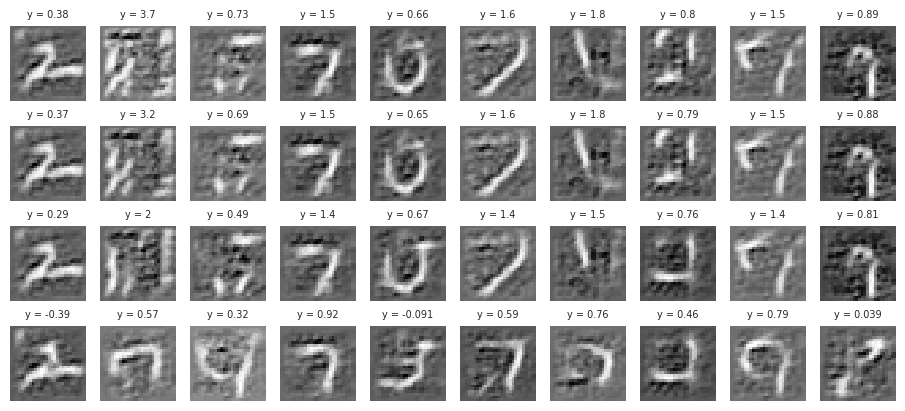

In [33]:
### Was: 'mc_ep600-b200-lr(0.005)_beta(1:0x0.5)_temp(0.05:lin-0.5)_gr(500)_(2024_04_23,14:55)'

  0%|                                                     | 0/4 [00:00<?, ?it/s]

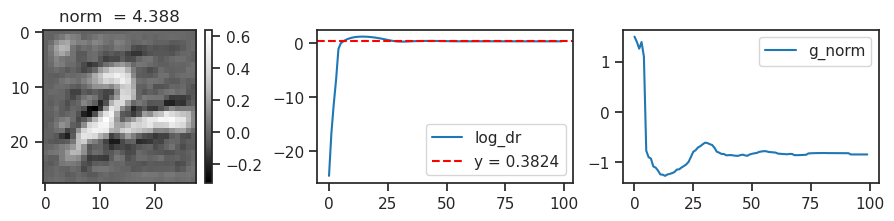

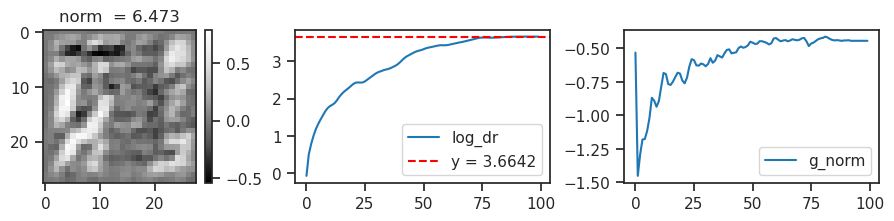

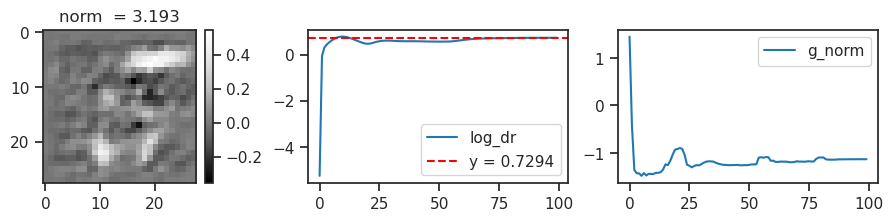

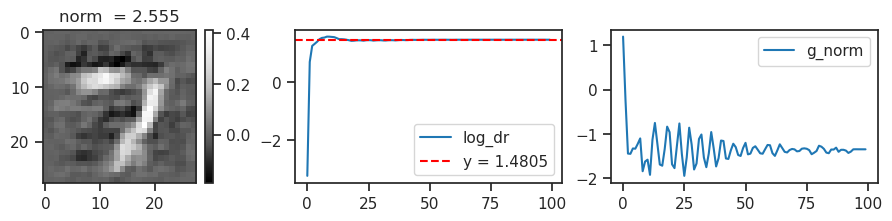

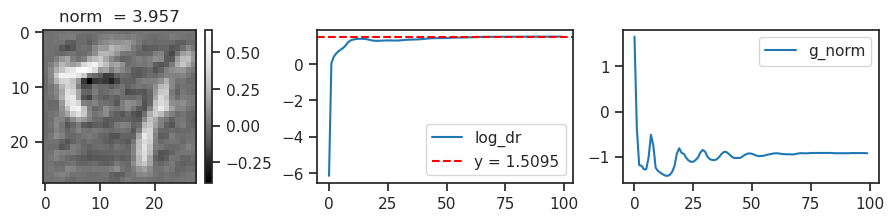

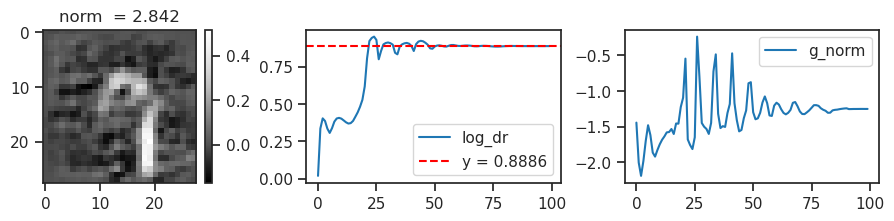

 25%|███████████▎                                 | 1/4 [00:17<00:52, 17.59s/it]

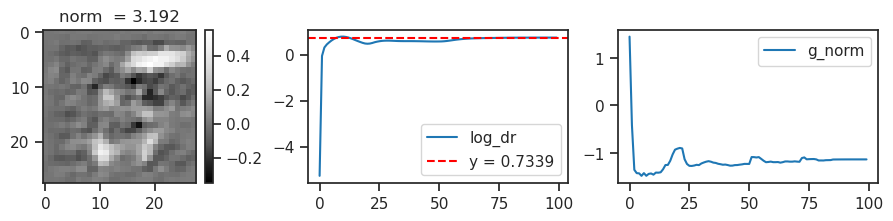

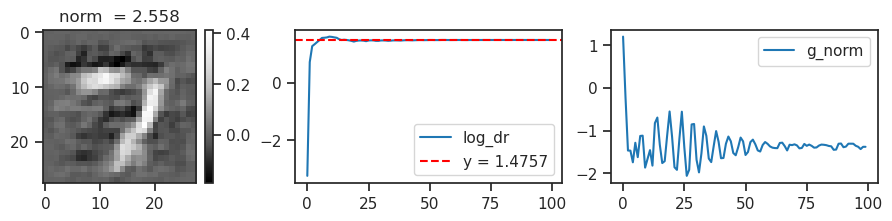

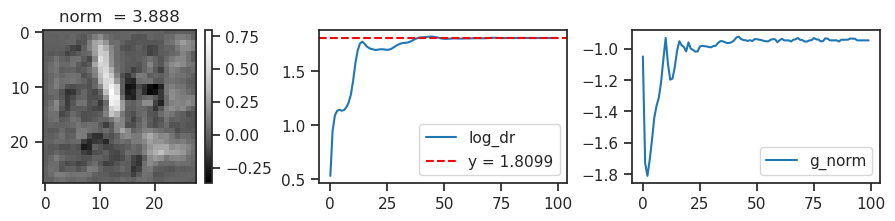

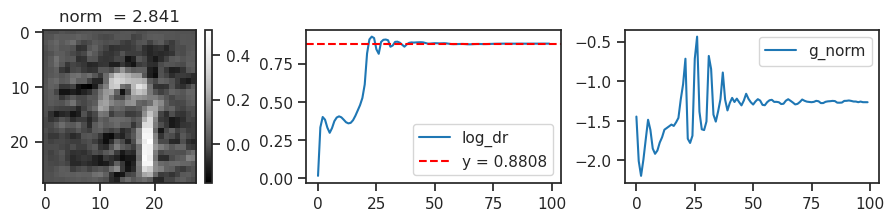

 50%|██████████████████████▌                      | 2/4 [00:35<00:35, 17.53s/it]

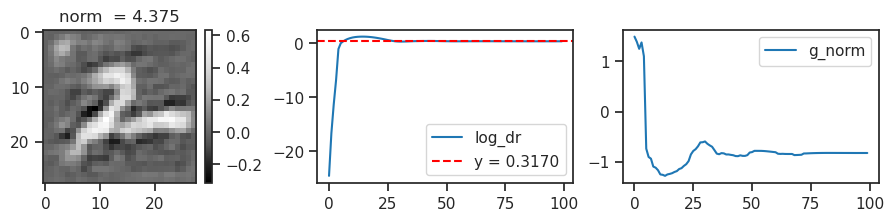

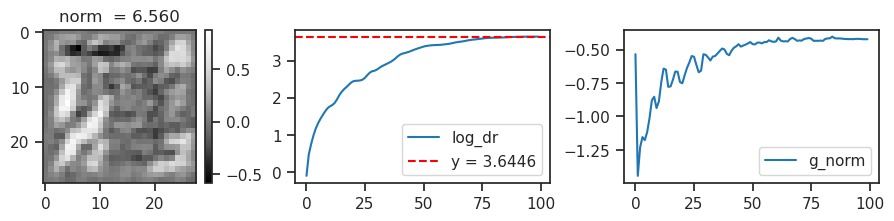

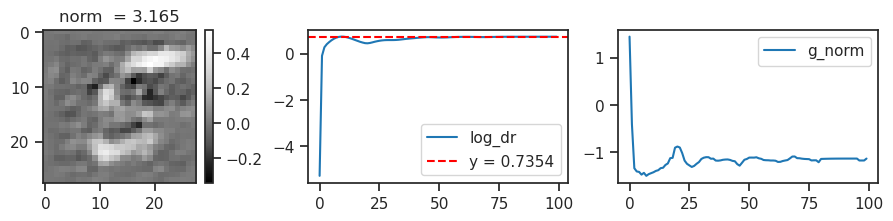

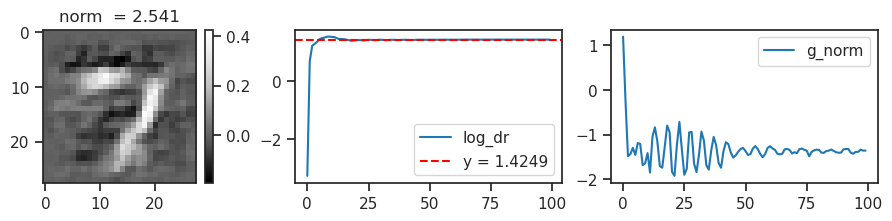

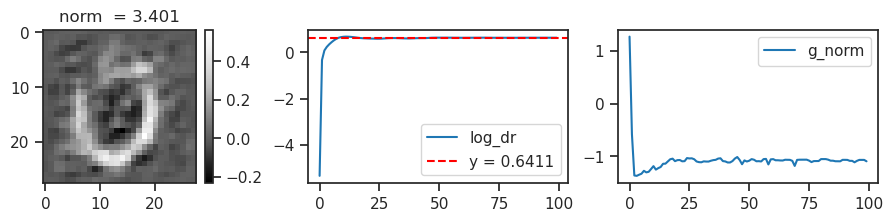

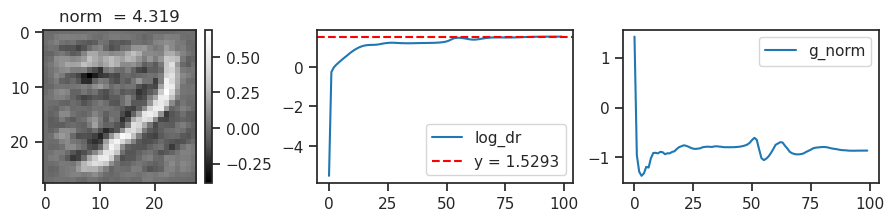

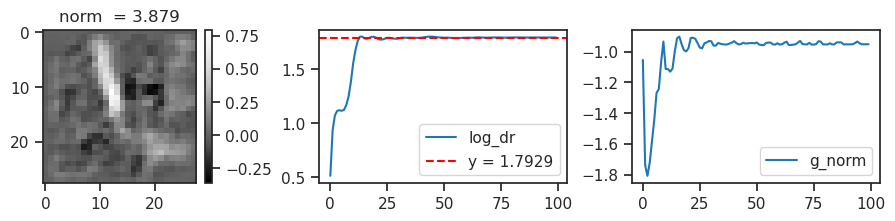

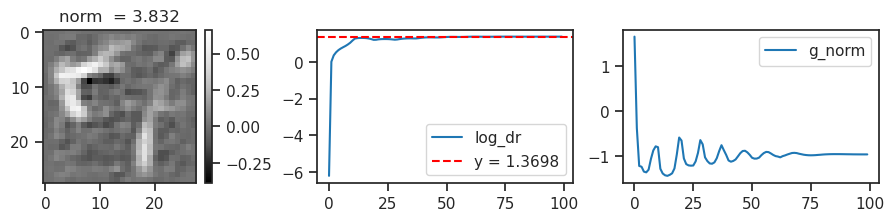

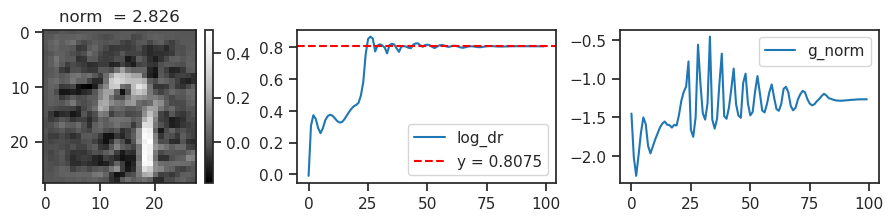

 75%|█████████████████████████████████▊           | 3/4 [00:53<00:18, 18.08s/it]

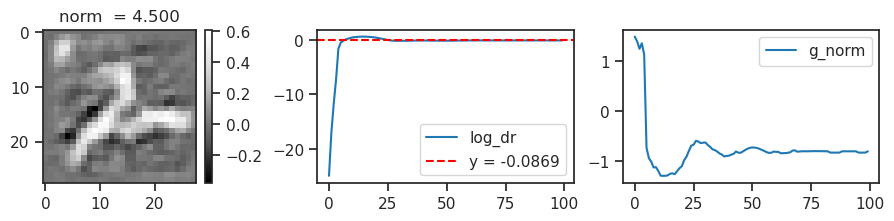

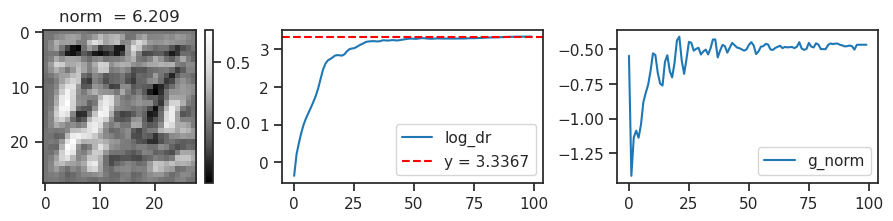

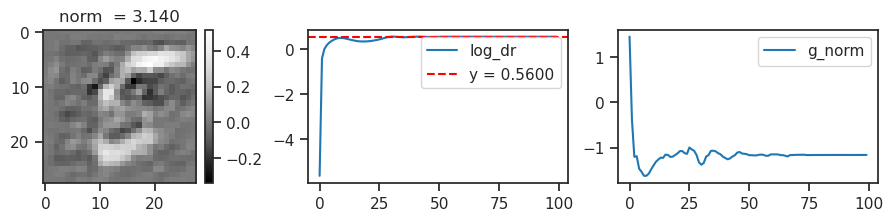

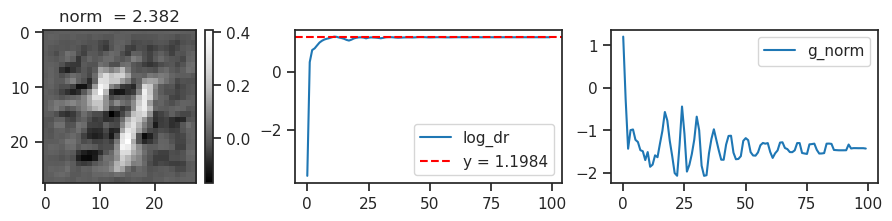

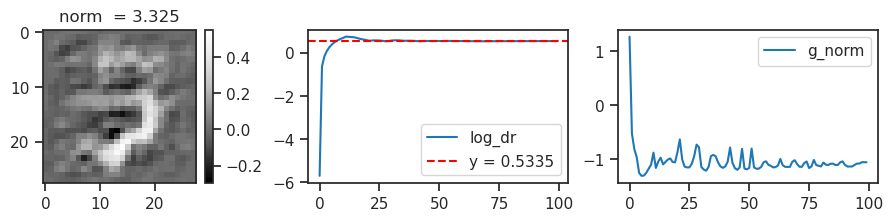

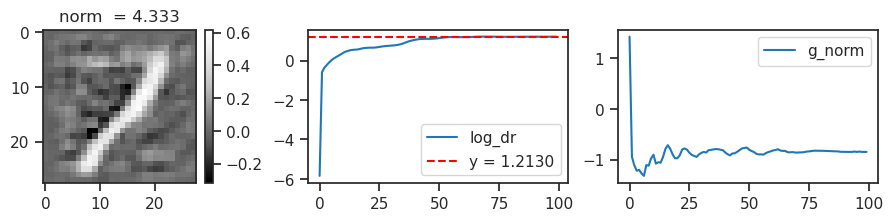

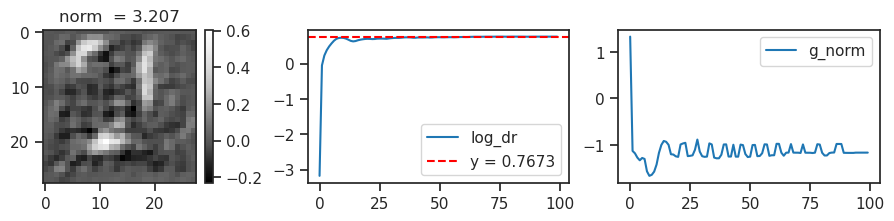

100%|█████████████████████████████████████████████| 4/4 [01:13<00:00, 18.33s/it]


In [34]:
alphas = [0, 0.001, 0.01, 0.1]
mei_all = {
    a: np.zeros((tr.model.cfg.n_latents, 28, 28))
    for a in alphas
}
y_all = {
    a: np.zeros(tr.model.cfg.n_latents)
    for a in alphas
}
for i, a in tqdm(enumerate(alphas), total=len(alphas), ncols=80):
    for j in range(tr.model.cfg.n_latents):
        mei_all[a][j], y_all[a][j] = _do_it(j, a, func_silence);

In [35]:
cmap = 'Greys_r'

fig, axes = create_figure(len(alphas), tr.model.cfg.n_latents, (9, 1.0 * len(alphas)), 'all', 'all', layout='constrained')
for j in range(tr.model.cfg.n_latents):
    for i, a in enumerate(alphas):
        axes[i, j].imshow(mei_all[a][j], cmap=cmap)
        axes[i, j].set_title(f"y = {y_all[a][j]:0.2g}", fontsize=7)
remove_ticks(axes)
plt.show()